In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score,make_scorer, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [10]:
dataset = fetch_california_housing()

In [11]:
dataset.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [12]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['Price'] = dataset.target

In [13]:
df.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Price         0
dtype: int64

In [14]:
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Price,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


In [15]:
X = df.drop('Price', axis = True).values
y = df['Price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
def print_metrics(model, y_true, y_pred):
    print(f'R2 : {r2_score(y_test, y_pred):.2f}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred):.2f}')
    

## Random Forest

In [78]:
scores = []
for i in range(10, 30, 5):
    model = RandomForestRegressor(n_estimators=100, max_depth=i,max_features='sqrt', random_state=42 )
    scores.append(np.mean(cross_val_score(model, X_train, y_train, cv = 5 )))

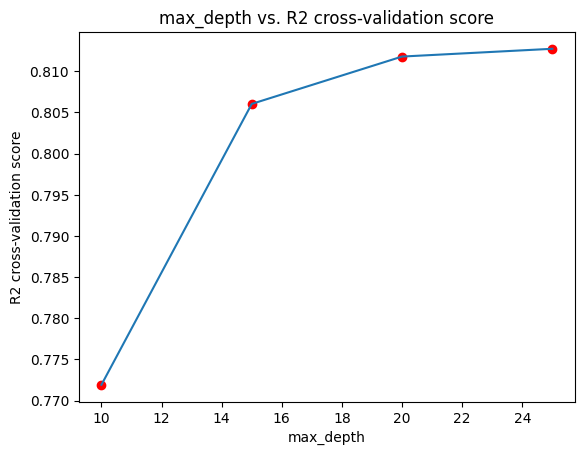

In [81]:
plt.scatter(range(10, 30, 5), scores, c = 'r')
plt.plot(range(10, 30, 5), scores)
plt.title('max_depth vs. R2 cross-validation score')
plt.xlabel('max_depth')
plt.ylabel('R2 cross-validation score')
plt.show()

In [17]:
model = RandomForestRegressor(n_estimators=500, max_depth=20,max_features='sqrt', random_state=42 )
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=500,
                      random_state=42)

In [18]:
y_pred = model.predict(X_test)
print_metrics(model, y_test, y_pred)

R2 : 0.81
MAE: 0.33
MSE: 0.24


## XGBoost

In [168]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=make_scorer(r2_score),
    cv=5,          
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


print("Best R²:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\A\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best R²: 0.8501387851231955
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Test R²: 0.8510388368815556


In [19]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=1,
    reg_lambda=3,
    n_jobs=-1,
    random_state=42
)

In [21]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print_metrics(model, y_test, y_pred)

R2 : 0.86
MAE: 0.28
MSE: 0.19


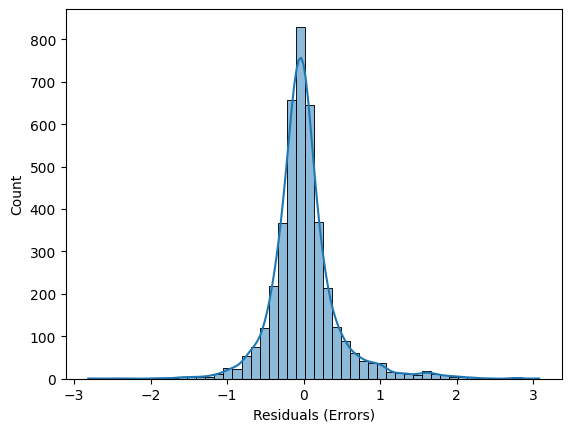

In [23]:
import seaborn as sns
residuals = y_test - model.predict(X_test)
sns.histplot(residuals, bins = 50, kde = True)
plt.xlabel('Residuals (Errors)')
plt.show()

## Catboost

In [24]:
model = CatBoostRegressor(
      iterations = 1000,
      learning_rate= 0.05,
      depth = 8, verbose=1000,
      l2_leaf_reg=3,
      random_seed=42,
      early_stopping_rounds=50)
print(f'Cross validation  score: {np.mean(cross_val_score(model, X_train, y_train, cv = 5 )):.4f}')

0:	learn: 1.1185004	total: 171ms	remaining: 2m 51s
999:	learn: 0.2882779	total: 16.3s	remaining: 0us
0:	learn: 1.1264136	total: 15.6ms	remaining: 15.5s
999:	learn: 0.2848325	total: 15.7s	remaining: 0us
0:	learn: 1.1224604	total: 16.6ms	remaining: 16.6s
999:	learn: 0.2919504	total: 17.9s	remaining: 0us
0:	learn: 1.1251815	total: 16.9ms	remaining: 16.8s
999:	learn: 0.2900988	total: 15.8s	remaining: 0us
0:	learn: 1.1188829	total: 18.2ms	remaining: 18.2s
999:	learn: 0.2876223	total: 15.6s	remaining: 0us
Cross validation  score: 0.8503


In [25]:
model.fit(X_train, y_train)

0:	learn: 1.1218818	total: 18.2ms	remaining: 18.2s
999:	learn: 0.3032645	total: 17.9s	remaining: 0us


In [26]:
y_pred = model.predict(X_test)
print_metrics(model, y_test, y_pred)

R2 : 0.85
MAE: 0.29
MSE: 0.19


## ANN (Artificial Neural network)

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [472]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model.fit( X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,callbacks=[early_stop],verbose=1)

Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.9492 - mae: 0.6682 - val_loss: 0.4662 - val_mae: 0.4798
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4016 - mae: 0.4478 - val_loss: 0.4042 - val_mae: 0.4412
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3738 - mae: 0.4276 - val_loss: 0.3885 - val_mae: 0.4448
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3549 - mae: 0.4155 - val_loss: 0.3816 - val_mae: 0.4163
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3440 - mae: 0.4064 - val_loss: 0.3615 - val_mae: 0.4075
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3300 - mae: 0.3964 - val_loss: 0.3601 - val_mae: 0.4044
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3248 - mae: 0.3920 - val_loss: 0.3504 - val_mae: 0.4053
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3222 - mae: 0.3879 - val_loss: 0.3401 - val_mae: 0.3980
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/

In [478]:
print(r2_score(y_train, model.predict(X_train)))

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.8140041523592778


In [483]:
print_metrics(model, y_test, y_pred)

R2 : 0.79
MAE: 0.36
MSE: 0.28
